# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize your data, then track how those summaries change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Import the `cytoflow` module.

In [1]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about some data.  `cytoflow` makes it easy to compute statistics for various subsets.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute the geometric mean of the `FITC-A` channel of each different `IP` condition with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset. The result is stored in the `statistics` attribute of an `Experiment`. The `statistics` attribute is a dictionary whose keys are the *names* of the operations that added the statistics:

In [4]:
ex2.statistics.keys()

dict_keys(['Conditions', 'ByIP'])

The value of each entry in `Experiment.statistics` is a `pandas.DataFrame` whose index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself. `ImportOp` stores a statistic called `Conditions` -- it's the conditions of each tube we loaded -- and `ByIP` is the statistic we just computed.

In [5]:
ex2.statistics['ByIP']

,FITC-A
IP,
0.0159,110.689216
0.0211,145.457491
0.0282,158.179844
0.0376,191.686432
0.0500,247.427608
0.0668,429.696322
0.0892,671.304186
0.1188,928.771756
0.1584,1190.565628


We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [6]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics["ByIP"][0:12]

FITC-A
IP     Replicate            
0.0159 1          102.937468
       2          115.299550
       3          114.317690
0.0211 1          136.798600
       2          146.395310
       3          153.673670
0.0282 1          151.769626
       2          159.617006
       3          163.376433
0.0376 1          193.639169
       2          193.623095
       3          187.855429

Note that the `pandas.DataFrame` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [7]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP").plot(ex2)

CytoflowViewError: ('plot_name', "You must use facets ['Replicate'] in either the plot variables or the plot name. Possible plot names: [1, 2, 3]")

Oops!  We forgot to specify how to plot the different `Replicate`s.  Each index of a statistic must be specified as either a variable or a facet of the plot, like so:

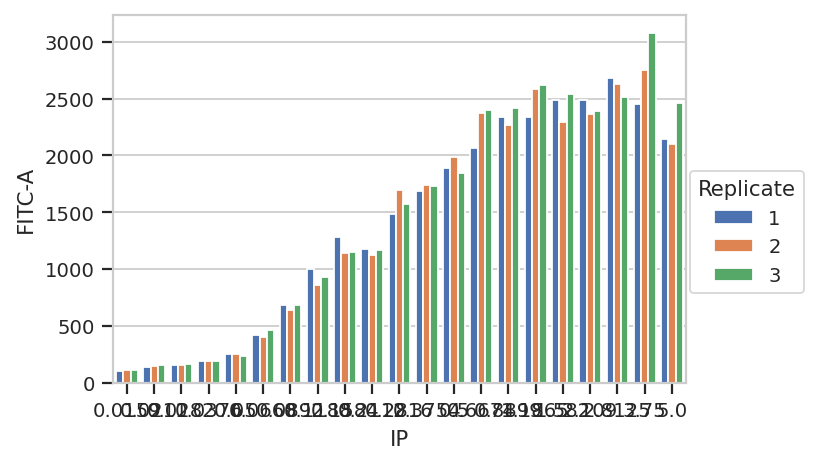

In [8]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Note that because a statistic can contain multiple columns, we have to specify which one of them to plot. Taking a term from machine learning, `cytoflow` calls each column of a statistic a `feature`. Thus, `feature = "FITC-A"` tells the `BarChartView` to plot the `FITC-A` column of the statistic. By default, `ChannelStatisticOp` creates a statistic with one feature, named the same as the channel the function was applied to. However, if your function returns a `pandas.Series`, the row names of the series become the column names.

---

A quick aside - sometimes you get ugly axes because of overlapping labels.  In this case, we want a wider plot.  While we can directly specify the height of a plot, we can't directly specify its width, only its aspect ratio (the ratio of the width to the height.)  `cytoflow` defaults to 1.5; in this case, let's widen it out to 4.  If this results in a plot that's wider than your browser, the Jupyter notebook will scale it down for you.

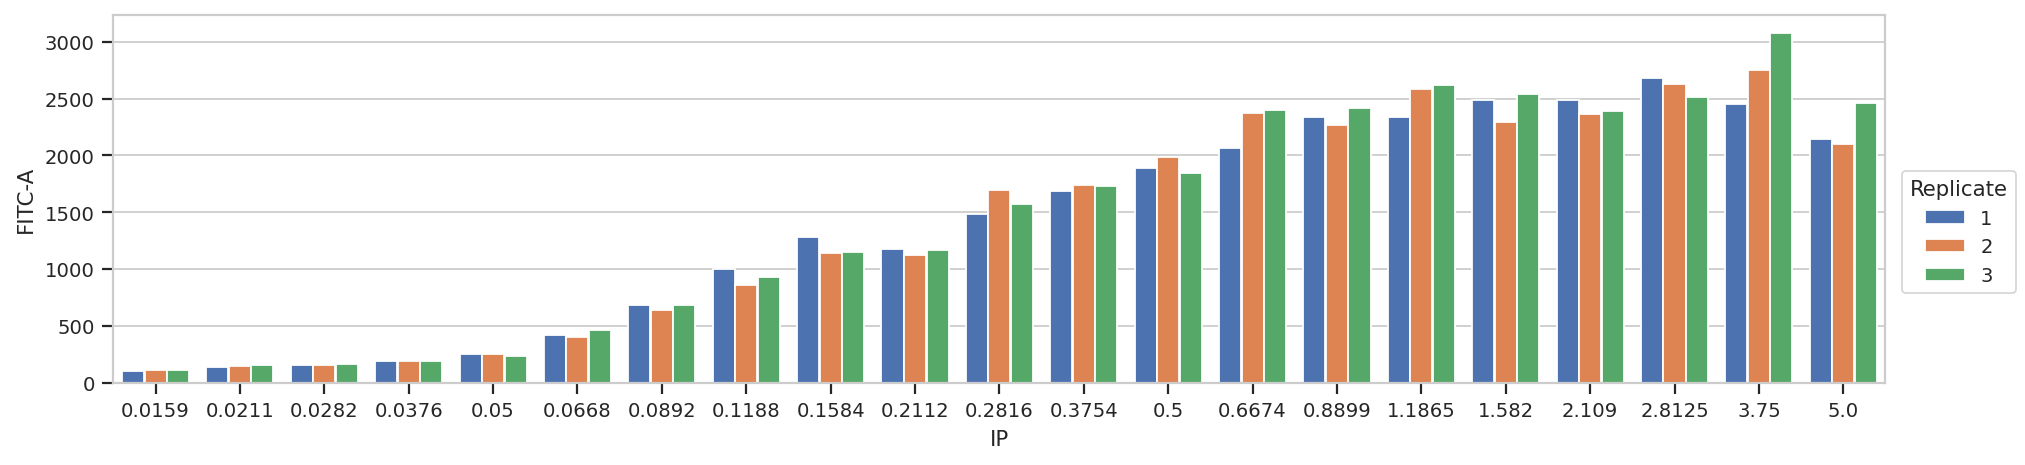

In [9]:
flow.BarChartView(statistic = "ByIP",
                  feature = "FITC-A",
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2, aspect = 4)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

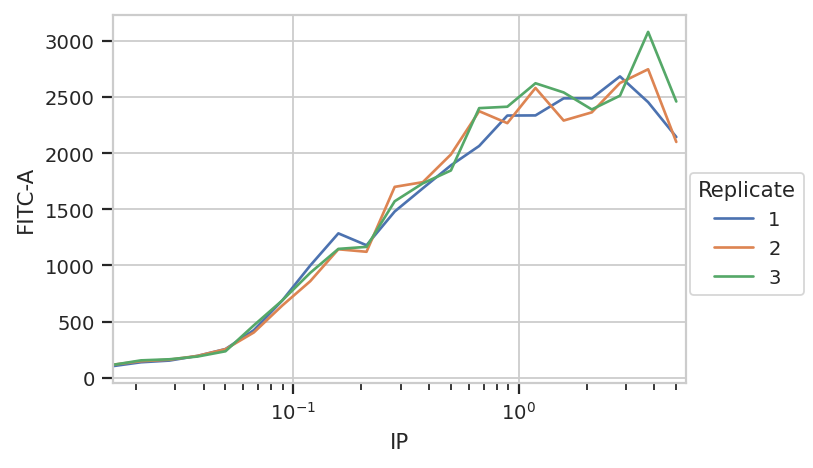

In [10]:
flow.Stats1DView(statistic = "ByIP",
                 feature = "FITC-A",
                 variable = "IP",
                 variable_scale = 'log',
                 huefacet = "Replicate").plot(ex2)

1D and 2D statistics views can also plot error bars; the high and low values must be features in the *same statistic*, which is pretty easy to do if the function you use in `ChannelStatisticOp` returns a `pandas.Series`. Here's an example that uses a lambda expression
to avoid defining a whole new function, computing the geometric mean and standard deviation of each subset:

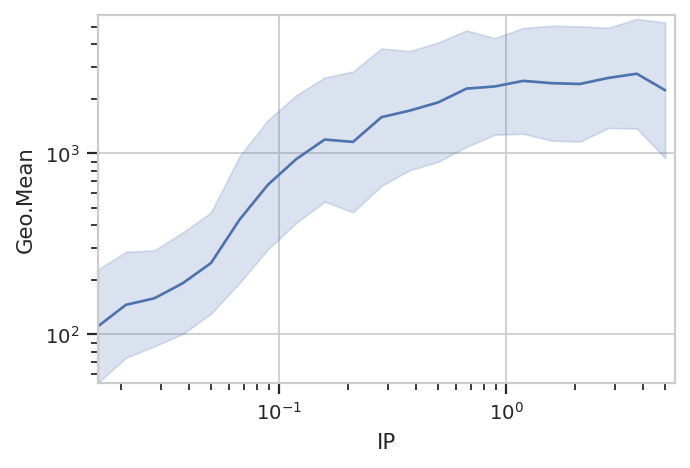

In [11]:
# While an arithmetic SD is usually plotted plus-or-minus the arithmetic mean, 
# a *geometric* SD is usually plotted (on a log scale!) multiplied-or-divided by the 
# geometric mean.  the function geom_sd_range is a convenience function that does this.

import pandas as pd
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = lambda x: pd.Series({"Geo.Mean" : flow.geom_mean(x),
                                                              "*SD" : flow.geom_mean(x) * flow.geom_sd(x),
                                                              "/SD" : flow.geom_mean(x) / flow.geom_sd(x)})).apply(ex)

flow.Stats1DView(statistic = "ByIP",
                 variable = "IP",
                 variable_scale = "log",
                 feature = "Geo.Mean",
                 scale = "log",
                 error_low = "/SD",
                 error_high = "*SD").plot(ex2, shade_error = True)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis. It also demonstrates that we can control the visual aspects of the plot by the parameters passed to `plot()`. The rule-of-thumb to remember is that the view object's attributes determine *what* is plotted; the parameters passed to *plot()* determine *how* it is plotted. We pass many of these parameters straight through to the underlying `seaborn` and `matplotlib` plotting functions; see the documentation of each view for details.

---

We can also plot two features against eachother, one on the X axis and one on the Y axis.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

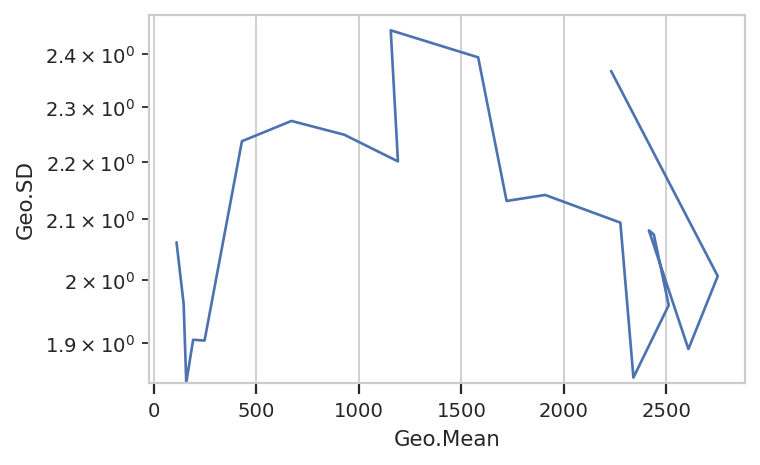

In [12]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = lambda x: pd.Series({"Geo.Mean" : flow.geom_mean(x),
                                                              "Geo.SD" : flow.geom_sd(x)})).apply(ex)

flow.Stats2DView(statistic = "ByIP",
                 variable = "IP",
                 xfeature = "Geo.Mean",
                 yfeature = "Geo.SD",
                 yscale = "log").plot(ex2)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

## Transforming statistics

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [13]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Now, the `Experiment` has a condition named `Above1000` that is `True` or `False` depending on whether that event's `FITC-A` channel is greater than 1000.  Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [14]:
ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len).apply(ex2)
ex3.statistics["Above1000"]

FITC-A
Above1000 IP            
False     0.0159   300.0
          0.0211   298.0
          0.0282   300.0
          0.0376   299.0
          0.0500   296.0
          0.0668   255.0
          0.0892   199.0
          0.1188   150.0
          0.1584   105.0
          0.2112   100.0
          0.2816    66.0
          0.3754    65.0
          0.5000    52.0
          0.6674    28.0
          0.8899    19.0
          1.1865    21.0
          1.5820    27.0
          2.1090    25.0
          2.8125    14.0
          3.7500    11.0
          5.0000    32.0
True      0.0211     2.0
          0.0376     1.0
          0.0500     4.0
          0.0668    45.0
          0.0892   101.0
          0.1188   150.0
          0.1584   195.0
          0.2112   200.0
          0.2816   234.0
          0.3754   235.0
          0.5000   248.0
          0.6674   272.0
          0.8899   281.0
          1.1865   279.0
          1.5820   273.0
          2.1090   275.0
          2.8125   286.0
          3.7500   289.0
          5.0000   268.0

And now we compute the proportion of `Above1000 == True` for each value of `IP`.  `TransformStatisticOp` applies a function to subsets of a statistic -- the function must take a single `pandas.Series` parameter and it may return either a single `float` value, in which case the operation is a reduction, or it may return a `pandas.Series` whose row names become the new column names of the new statistic, or it can return a `pandas.Series` with the same index as the passed series, in which case it is a transformation. (In this last case, leave `by` unset.) Here, we're applying a `lambda` function to convert each `IP` subset from length into proportion.

In [15]:
import pandas as pd

ex4 = flow.TransformStatisticOp(name = "PropAbove1000",
                                statistic = "Above1000",
                                feature = "FITC-A",
                                by = ["IP"],
                                function = lambda a: a / a.sum()).apply(ex3)

CytoflowOpError: ('function', "The first call of 'function' returned series with index of Index([False], dtype='bool', name='Above1000'), but the call on group (0.0211,) returned a series with index Index([False, True], dtype='bool', name='Above1000'). All returned series must have the same index!")

That's a pretty ugly error -- but the cause is straightforward. Look at the values in the statistic above and notice how there is an entry for `Above1000 == False, IP == 0.0159` but there isn't a corresponding entry for `Above1000 == True, IP == 0.0159`? When we called `a / a.sum()` on the subset of the statistic with `IP == 0.0159`, it returned a `Series` with only one row -- `False`. However, when we did the same function on the subset of the statistic with `IP == 0.0211`, now that subset has two rows, `False` and `True` -- and when we compute `a / a.sum()`, we get a `Series` that similarly has two rows.

This is a not uncommon situation. You can solve it by setting `ignore_incomplete_groups` to `True`.

In [16]:
ex4 = flow.TransformStatisticOp(name = "PropAbove1000",
                                statistic = "Above1000",
                                feature = "FITC-A",
                                by = ["IP"],
                                function = lambda a: a / a.sum(),
                                ignore_incomplete_groups = True).apply(ex3)

ex4.statistics["PropAbove1000"][0:8]

,False,True
IP,,
0.0211,0.993333,0.006667
0.0376,0.996667,0.003333
0.0500,0.986667,0.013333
0.0668,0.850000,0.150000
0.0892,0.663333,0.336667
0.1188,0.500000,0.500000
0.1584,0.350000,0.650000
0.2112,0.333333,0.666667


Note that because our lambda function returns a small `pandas.Series` with rows named `False` and `True`, the columns in our new statistic are also named `False` and `True`. Now we can plot the `True` column of the new statistic.

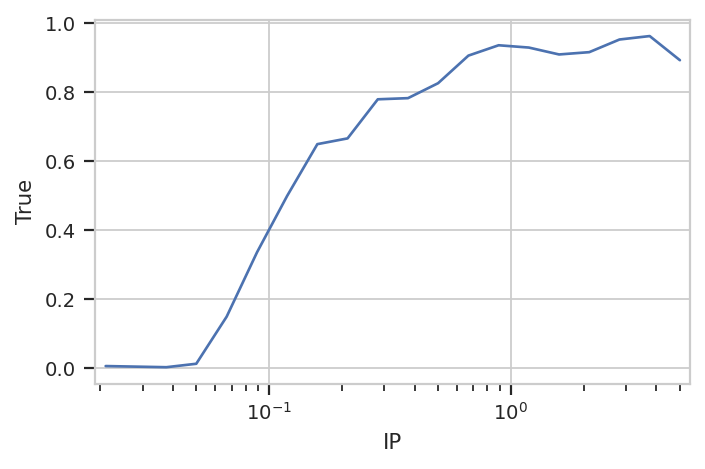

In [17]:
flow.Stats1DView(statistic = "PropAbove1000",
                 feature = "True",
                 variable = "IP",
                 variable_scale = "log").plot(ex4)

## Statistics from data-driven modules

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too. Let's look at a quick example, starting by re-loading the entire yeast induction dataset:

In [18]:
import cytoflow as flow
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))

    
ex = flow.ImportOp(conditions = {'IP' : "float"},
                   tubes = tubes).apply()

For this example, we'll use the `GaussianMixtureOp` operation. It adds a statistic for each component of the mixture model it fits, containing the mean, standard deviation, and a few other statistics (see the docs for details):

In [19]:
op = flow.GaussianMixtureOp(name = "Gauss",
                            channels = ["FITC-A"],
                            scale = {"FITC-A" : 'logicle'},
                            by = ["IP"],
                            num_components = 1)
op.estimate(ex)
ex2 = op.apply(ex)
ex2.statistics["Gauss"]

,,FITC-A Mean,FITC-A SD,FITC-A Interval Low,FITC-A Interval High
IP,Component,,,,
0.0159,1,114.867593,6.044478,56.944599,224.178352
0.0211,1,146.760865,3.206172,80.365347,265.784241
0.0282,1,161.831942,3.483374,88.275085,295.421818
0.0376,1,188.241811,4.164093,101.184975,350.418214
0.0500,1,252.533895,6.484476,127.952042,502.065649
0.0668,1,415.359435,9.197695,195.235139,894.571209
0.0892,1,675.335896,9.728315,310.618328,1484.661773
0.1188,1,976.574632,10.505229,437.615067,2200.01757
0.1584,1,1212.127491,10.465049,542.10246,2732.441099


Many operations also have a "default" view which provides more information about how they ran. For example, the `GaussianMixtureOp` class has a `default_view()` member that returns a view which plots the underlying data as well as the gaussian curves that were fit:

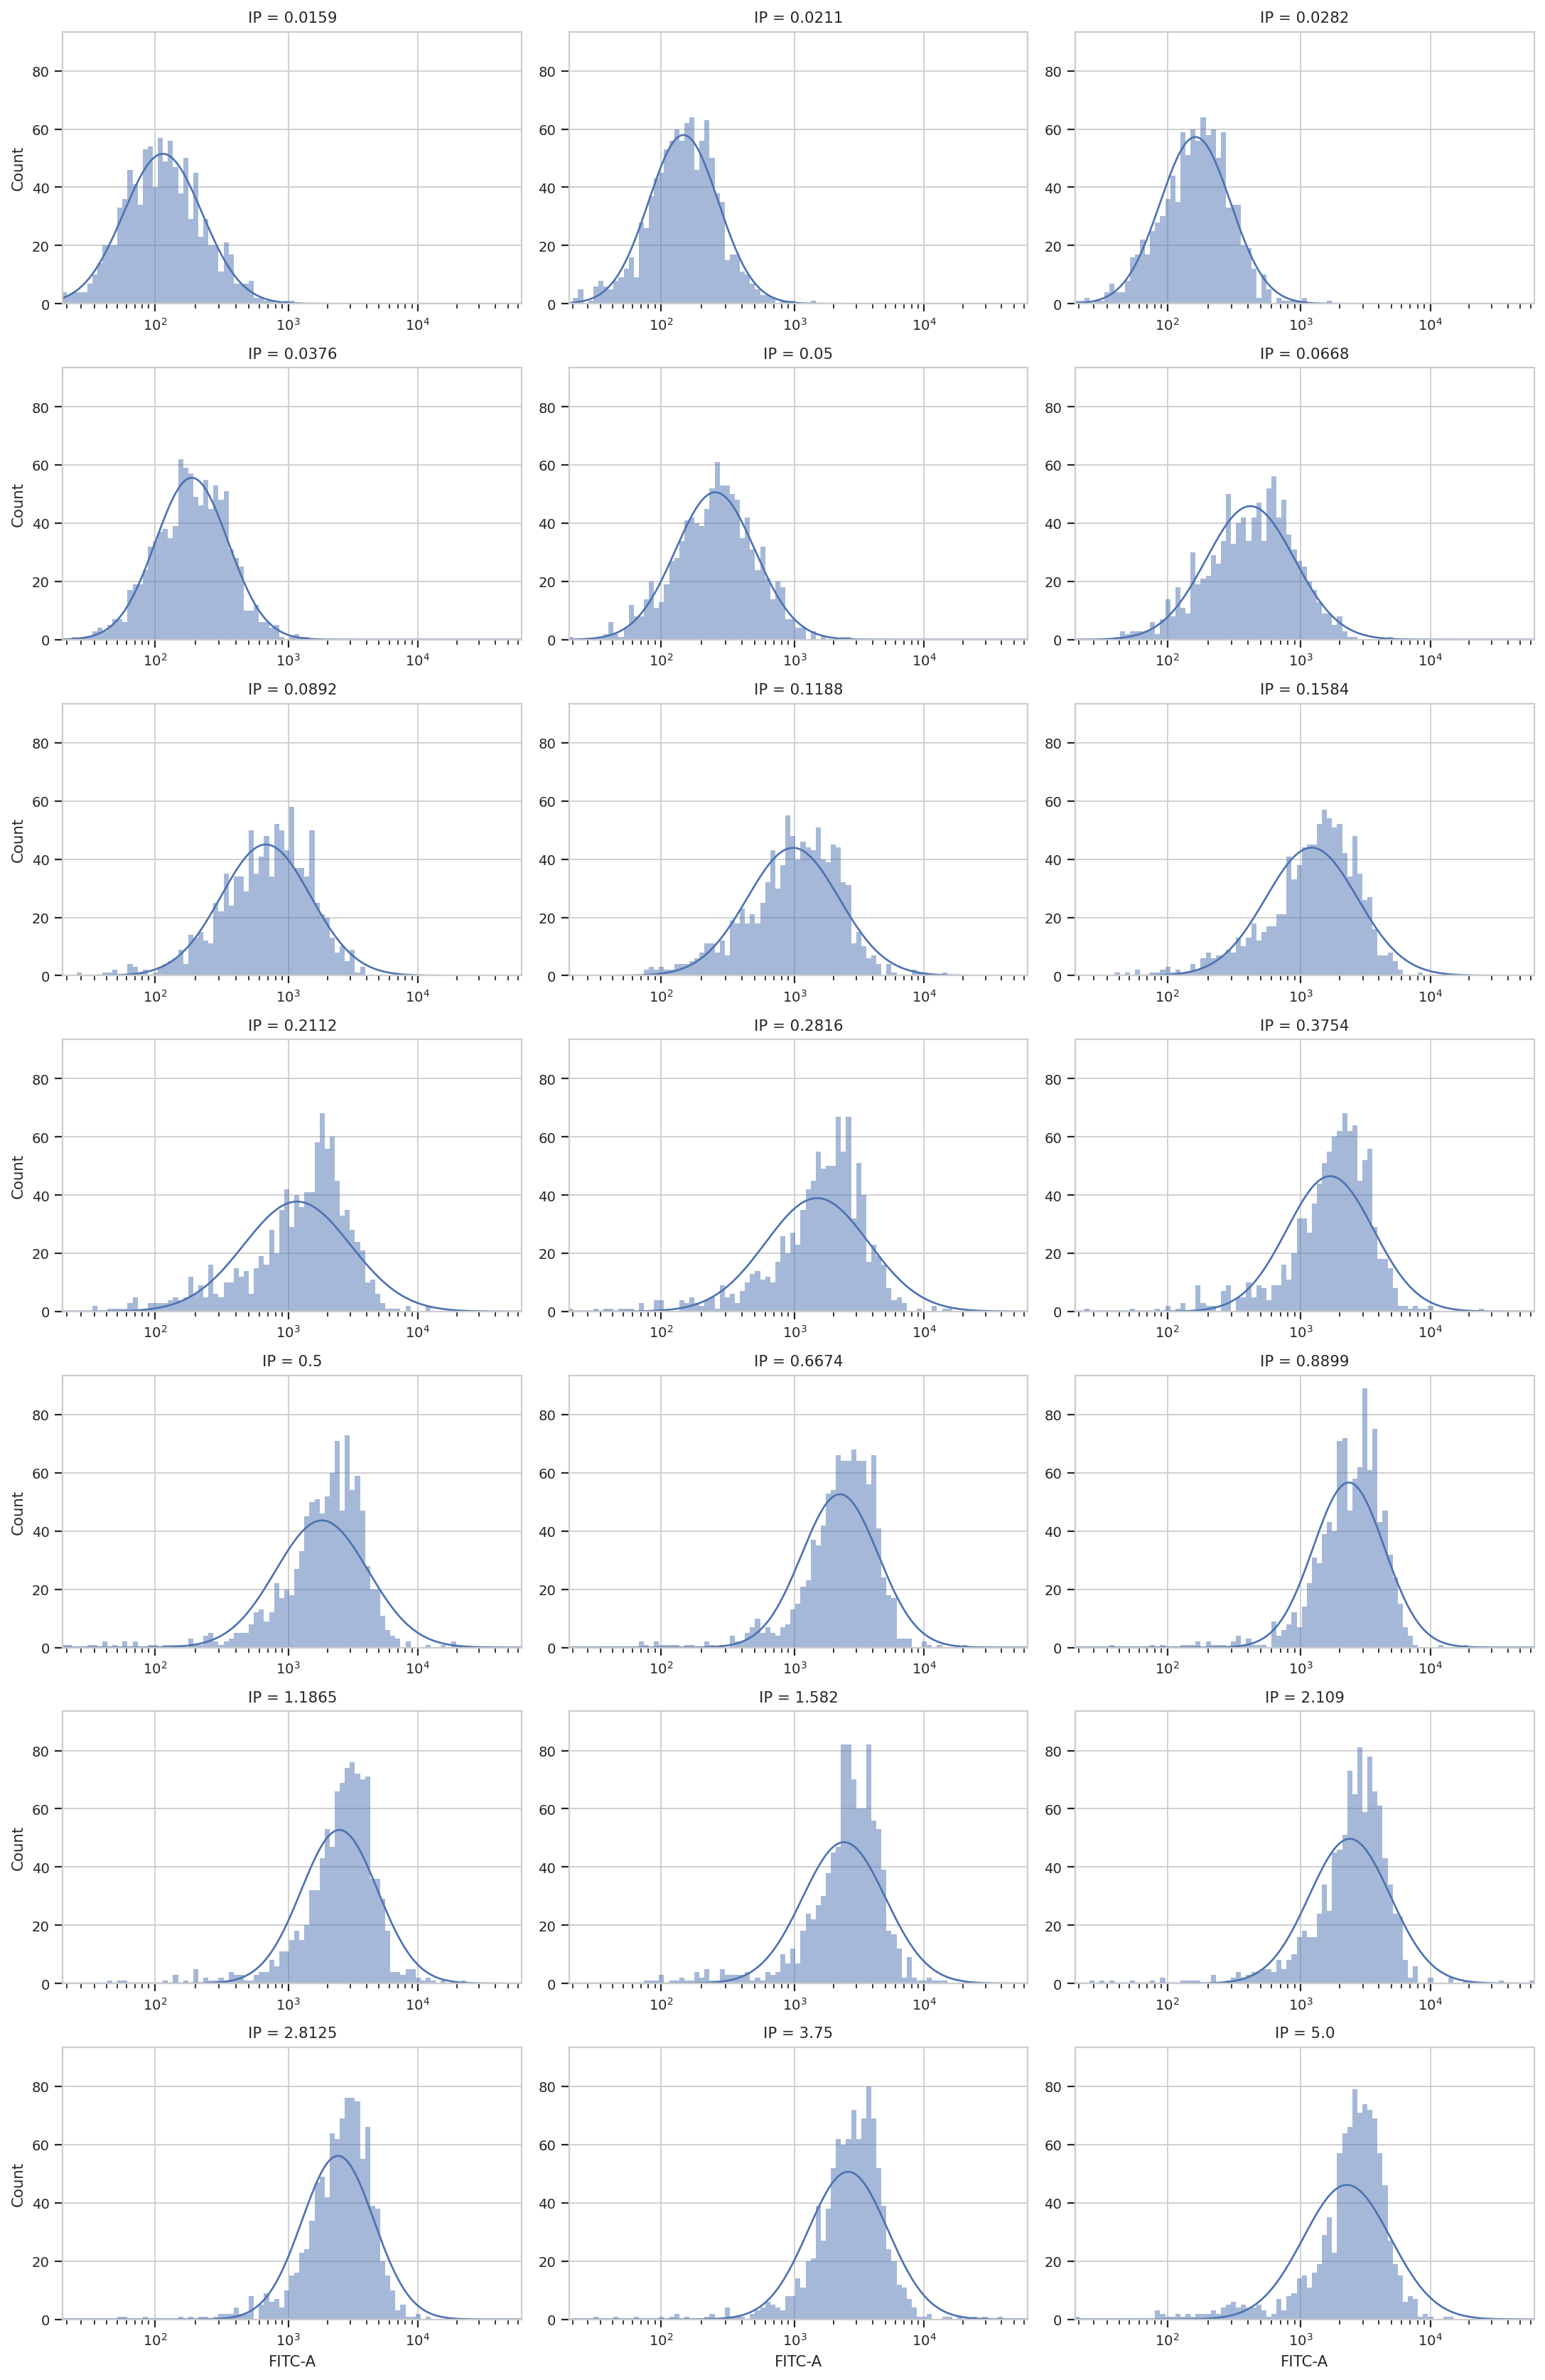

In [20]:
op.default_view(xfacet = "IP").plot(ex2, col_wrap = 3)

Let's plot the mean as it varies with IP concentration, along with the interval +/- one standard deviation:

/home/brian/src/cytoflow/cytoflow/views/base_views.py:862: CytoflowViewWarning: Only one value for level Component; dropping it.


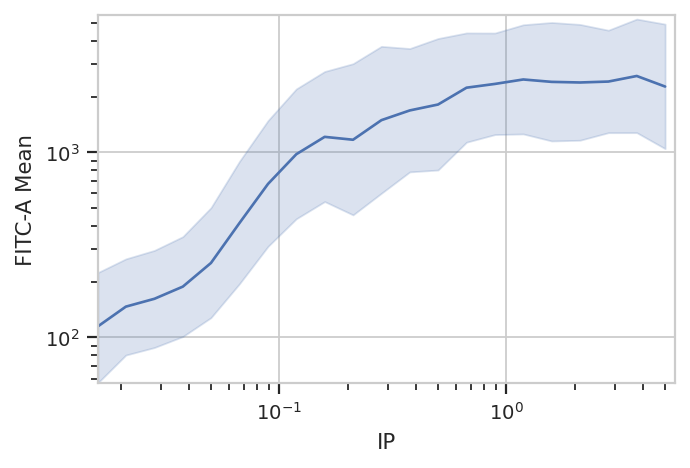

In [21]:
flow.Stats1DView(statistic = "Gauss",
                 feature = "FITC-A Mean",
                 variable = "IP",
                 variable_scale = "log",
                 scale = "log",
                 error_low = "FITC-A Interval Low",
                 error_high = "FITC-A Interval High").plot(ex2, shade_error = True)